In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## Model

In [3]:
import torch
print(torch.__version__)


2.5.1+cu121


In [4]:
df = pd.read_csv('manual_cleaned_emotion_classify_data.csv')
texts = df['Comment_clean'].astype(str).tolist()
labels = df['Emotion'].astype(str).tolist()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

Classes: ['anger' 'fear' 'joy']


Dataset class

In [5]:
class TransformerTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        # remove extra batch dimension (squeeze)
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item


Training

In [ ]:
def train_transformer_model(model_name, model_ckpt,
                            X_train_texts, y_train,
                            X_test_texts, y_test,
                            num_classes,
                            epochs=3,
                            batch_size=16,
                            max_len=64,
                            lr=2e-5):

    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    train_dataset = TransformerTextDataset(X_train_texts, y_train, tokenizer, max_len=max_len)
    test_dataset  = TransformerTextDataset(X_test_texts,  y_test,  tokenizer, max_len=max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_ckpt,
        num_labels=num_classes,
        use_safetensors=True
    )
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * batch['input_ids'].size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch['labels']).sum().item()
            total += batch['labels'].size(0)

        epoch_loss = total_loss / total
        epoch_acc = correct / total
        print(f"[{model_name}] Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            labels = batch['labels']
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.numpy())

    acc = accuracy_score(all_targets, all_preds)
    report = classification_report(
        all_targets,
        all_preds,
        target_names=label_encoder.classes_,
        output_dict=True
    )
    print(f"[{model_name}] Test Accuracy: {acc:.4f}")
    return acc, report


c:\Users\osen\Desktop\programming project\nlp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
transformer_models = {
    "BERT-base":    "bert-base-uncased",
    "DistilBERT":   "distilbert-base-uncased",
    "RoBERTa-base": "roberta-base",
    "ALBERT":       "albert-base-v2",
    "MiniLM":       "microsoft/MiniLM-L12-H384-uncased"
}


In [9]:
results_tf = {}
EPOCHS = 15
BATCH_SIZE = 16
MAX_LEN = 64

for name, ckpt in transformer_models.items():
    print(f"\n=== Training {name} ({ckpt}) ===")
    acc, report = train_transformer_model(
        model_name=name,
        model_ckpt=ckpt,
        X_train_texts=X_train_texts,
        y_train=y_train,
        X_test_texts=X_test_texts,
        y_test=y_test,
        num_classes=num_classes,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        max_len=MAX_LEN,
        lr=2e-5
    )
    results_tf[name] = {
        'accuracy': acc,
        'report': report
    }



=== Training BERT-base (bert-base-uncased) ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\osen\AppData\Local\Temp\ipykernel_22412\2283957498.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(label, dtype=torch.long)


[BERT-base] Epoch 1/15 - Loss: 0.9039, Acc: 0.5498
[BERT-base] Epoch 2/15 - Loss: 0.1475, Acc: 0.9516
[BERT-base] Epoch 3/15 - Loss: 0.0558, Acc: 0.9808
[BERT-base] Epoch 4/15 - Loss: 0.0352, Acc: 0.9880
[BERT-base] Epoch 5/15 - Loss: 0.0213, Acc: 0.9922
[BERT-base] Epoch 6/15 - Loss: 0.0153, Acc: 0.9945
[BERT-base] Epoch 7/15 - Loss: 0.0202, Acc: 0.9924
[BERT-base] Epoch 8/15 - Loss: 0.0095, Acc: 0.9964
[BERT-base] Epoch 9/15 - Loss: 0.0056, Acc: 0.9985
[BERT-base] Epoch 10/15 - Loss: 0.0040, Acc: 0.9989
[BERT-base] Epoch 11/15 - Loss: 0.0049, Acc: 0.9985
[BERT-base] Epoch 12/15 - Loss: 0.0023, Acc: 0.9994
[BERT-base] Epoch 13/15 - Loss: 0.0019, Acc: 0.9996
[BERT-base] Epoch 14/15 - Loss: 0.0010, Acc: 0.9998
[BERT-base] Epoch 15/15 - Loss: 0.0014, Acc: 0.9994
[BERT-base] Test Accuracy: 0.9697

=== Training DistilBERT (distilbert-base-uncased) ===


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: e8381a80-d553-48cb-99e2-f020e53dbab5)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\osen\AppData\Local\Temp\ipykernel_22412\2283957498.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(label, dtype=torch.long)


[DistilBERT] Epoch 1/15 - Loss: 0.7682, Acc: 0.6252
[DistilBERT] Epoch 2/15 - Loss: 0.1403, Acc: 0.9549
[DistilBERT] Epoch 3/15 - Loss: 0.0549, Acc: 0.9794
[DistilBERT] Epoch 4/15 - Loss: 0.0354, Acc: 0.9853
[DistilBERT] Epoch 5/15 - Loss: 0.0275, Acc: 0.9899
[DistilBERT] Epoch 6/15 - Loss: 0.0155, Acc: 0.9941
[DistilBERT] Epoch 7/15 - Loss: 0.0150, Acc: 0.9947
[DistilBERT] Epoch 8/15 - Loss: 0.0104, Acc: 0.9962
[DistilBERT] Epoch 9/15 - Loss: 0.0155, Acc: 0.9933
[DistilBERT] Epoch 10/15 - Loss: 0.0074, Acc: 0.9971
[DistilBERT] Epoch 11/15 - Loss: 0.0042, Acc: 0.9987
[DistilBERT] Epoch 12/15 - Loss: 0.0043, Acc: 0.9981
[DistilBERT] Epoch 13/15 - Loss: 0.0028, Acc: 0.9992
[DistilBERT] Epoch 14/15 - Loss: 0.0027, Acc: 0.9994
[DistilBERT] Epoch 15/15 - Loss: 0.0014, Acc: 1.0000
[DistilBERT] Test Accuracy: 0.9689

=== Training RoBERTa-base (roberta-base) ===


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 5baa05aa-f162-4ebc-b87c-10d3a37b9e15)')' thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\osen\AppData\Local\Temp\ipykernel_22412\2283957498.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(label, dtype=torch.long)


[RoBERTa-base] Epoch 1/15 - Loss: 0.7704, Acc: 0.6096
[RoBERTa-base] Epoch 2/15 - Loss: 0.1502, Acc: 0.9493
[RoBERTa-base] Epoch 3/15 - Loss: 0.0761, Acc: 0.9703
[RoBERTa-base] Epoch 4/15 - Loss: 0.0454, Acc: 0.9810
[RoBERTa-base] Epoch 5/15 - Loss: 0.0468, Acc: 0.9804
[RoBERTa-base] Epoch 6/15 - Loss: 0.0319, Acc: 0.9872
[RoBERTa-base] Epoch 7/15 - Loss: 0.0257, Acc: 0.9886
[RoBERTa-base] Epoch 8/15 - Loss: 0.0235, Acc: 0.9891
[RoBERTa-base] Epoch 9/15 - Loss: 0.0175, Acc: 0.9924
[RoBERTa-base] Epoch 10/15 - Loss: 0.0170, Acc: 0.9943
[RoBERTa-base] Epoch 11/15 - Loss: 0.0129, Acc: 0.9952
[RoBERTa-base] Epoch 12/15 - Loss: 0.0117, Acc: 0.9954
[RoBERTa-base] Epoch 13/15 - Loss: 0.0082, Acc: 0.9973
[RoBERTa-base] Epoch 14/15 - Loss: 0.0073, Acc: 0.9966
[RoBERTa-base] Epoch 15/15 - Loss: 0.0061, Acc: 0.9977
[RoBERTa-base] Test Accuracy: 0.9722

=== Training ALBERT (albert-base-v2) ===


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 43a36b30-db5c-410d-b1ca-26471ae10818)')' thrown while requesting HEAD https://huggingface.co/albert-base-v2/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\osen\AppData\Local\Temp\ipykernel_22412\2283957498.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(label, dtype=torch.long)


[ALBERT] Epoch 1/15 - Loss: 0.8773, Acc: 0.5652
[ALBERT] Epoch 2/15 - Loss: 0.2459, Acc: 0.9227
[ALBERT] Epoch 3/15 - Loss: 0.1173, Acc: 0.9579
[ALBERT] Epoch 4/15 - Loss: 0.0662, Acc: 0.9716
[ALBERT] Epoch 5/15 - Loss: 0.0359, Acc: 0.9859
[ALBERT] Epoch 6/15 - Loss: 0.0449, Acc: 0.9810
[ALBERT] Epoch 7/15 - Loss: 0.0303, Acc: 0.9859
[ALBERT] Epoch 8/15 - Loss: 0.0215, Acc: 0.9897
[ALBERT] Epoch 9/15 - Loss: 0.0178, Acc: 0.9918
[ALBERT] Epoch 10/15 - Loss: 0.0169, Acc: 0.9926
[ALBERT] Epoch 11/15 - Loss: 0.0123, Acc: 0.9947
[ALBERT] Epoch 12/15 - Loss: 0.0076, Acc: 0.9977
[ALBERT] Epoch 13/15 - Loss: 0.0060, Acc: 0.9981
[ALBERT] Epoch 14/15 - Loss: 0.0040, Acc: 0.9985
[ALBERT] Epoch 15/15 - Loss: 0.0019, Acc: 0.9998
[ALBERT] Test Accuracy: 0.9663

=== Training MiniLM (microsoft/MiniLM-L12-H384-uncased) ===


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 585046b5-64f8-4401-997e-c94d82e3ae02)')' thrown while requesting HEAD https://huggingface.co/microsoft/MiniLM-L12-H384-uncased/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\osen\AppData\Local\Temp\ipykernel_22412\2283957498.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(label, dtype=torch.long)


[MiniLM] Epoch 1/15 - Loss: 1.0047, Acc: 0.4456
[MiniLM] Epoch 2/15 - Loss: 0.4394, Acc: 0.8400
[MiniLM] Epoch 3/15 - Loss: 0.1768, Acc: 0.9480
[MiniLM] Epoch 4/15 - Loss: 0.1089, Acc: 0.9657
[MiniLM] Epoch 5/15 - Loss: 0.0704, Acc: 0.9783
[MiniLM] Epoch 6/15 - Loss: 0.0493, Acc: 0.9813
[MiniLM] Epoch 7/15 - Loss: 0.0488, Acc: 0.9817
[MiniLM] Epoch 8/15 - Loss: 0.0418, Acc: 0.9838
[MiniLM] Epoch 9/15 - Loss: 0.0355, Acc: 0.9853
[MiniLM] Epoch 10/15 - Loss: 0.0232, Acc: 0.9907
[MiniLM] Epoch 11/15 - Loss: 0.0245, Acc: 0.9918
[MiniLM] Epoch 12/15 - Loss: 0.0188, Acc: 0.9931
[MiniLM] Epoch 13/15 - Loss: 0.0190, Acc: 0.9920
[MiniLM] Epoch 14/15 - Loss: 0.0183, Acc: 0.9935
[MiniLM] Epoch 15/15 - Loss: 0.0173, Acc: 0.9931
[MiniLM] Test Accuracy: 0.9672


In [10]:
# save results

rows = []

for model_name, model_data in results_tf.items():
    acc = model_data["accuracy"]
    report = model_data["report"]

    for cls, metrics in report.items():
        # metrics might include accuracy, skip that row format
        if isinstance(metrics, dict):
            rows.append({
                "model": model_name,
                "class": cls,
                "accuracy": acc,
                "precision": metrics.get("precision", None),
                "recall": metrics.get("recall", None),
                "f1-score": metrics.get("f1-score", None),
                "support": metrics.get("support", None),
            })

tf_df = pd.DataFrame(rows)
tf_df.to_csv("transformer_model_results.csv", index=False)

## Graphs

In [13]:
tf_df = pd.read_csv('transformer_model_results.csv')
tf_df

,model,class,accuracy,precision,recall,f1-score,support
0,BERT-base,anger,0.969697,0.972081,0.957500,0.964736,400.0
1,BERT-base,fear,0.969697,0.950000,0.979381,0.964467,388.0
2,BERT-base,joy,0.969697,0.987310,0.972500,0.979849,400.0
3,BERT-base,macro avg,0.969697,0.969797,0.969794,0.969684,1188.0
4,BERT-base,weighted avg,0.969697,0.969997,0.969697,0.969736,1188.0
5,DistilBERT,anger,0.968855,0.981771,0.942500,0.961735,400.0
6,DistilBERT,fear,0.968855,0.945274,0.979381,0.962025,388.0
7,DistilBERT,joy,0.968855,0.980100,0.985000,0.982544,400.0
8,DistilBERT,macro avg,0.968855,0.969048,0.968960,0.968768,1188.0
9,DistilBERT,weighted avg,0.968855,0.969288,0.968855,0.968836,1188.0


Accuracy comparison

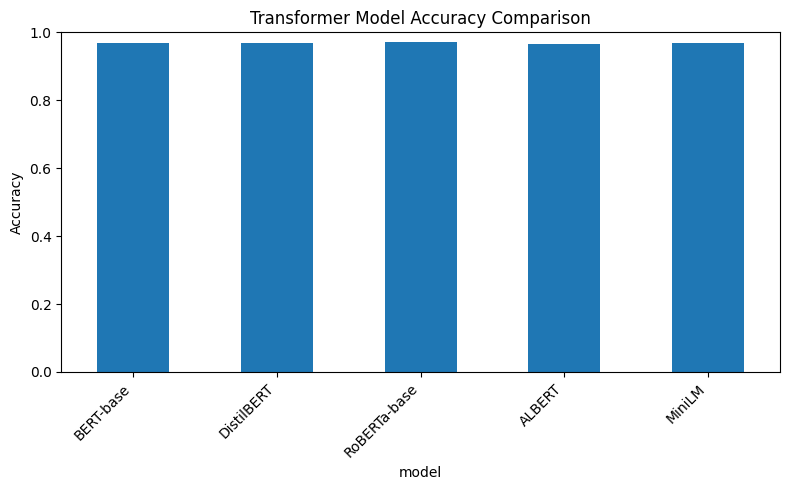

In [16]:
acc_df = (
    tf_df[tf_df["class"] == "macro avg"][["model", "accuracy"]]
    .drop_duplicates()
    .set_index("model")
)

acc_df.plot(kind='bar', legend=False, figsize=(8,5))
plt.ylabel('Accuracy')
plt.title('Transformer Model Accuracy Comparison')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Macro precision, recall, F1 per model

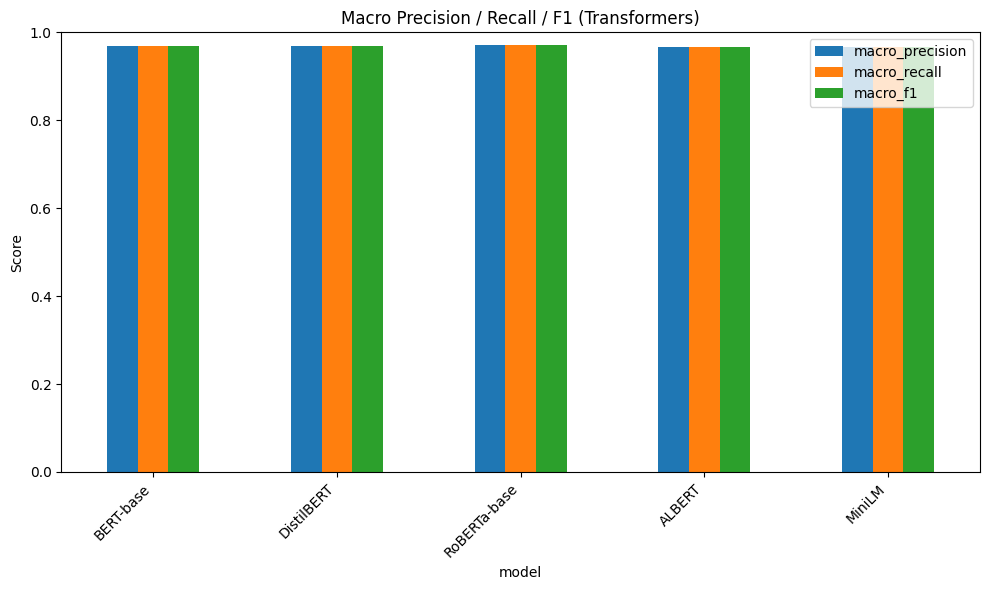

In [17]:
macro_df = (
    tf_df[tf_df["class"] == "macro avg"][["model", "precision", "recall", "f1-score"]]
    .drop_duplicates()
    .set_index("model")
)

macro_df.columns = ["macro_precision", "macro_recall", "macro_f1"]

macro_df.plot(kind='bar', figsize=(10,6))
plt.ylabel('Score')
plt.title('Macro Precision / Recall / F1 (Transformers)')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Per-class F1-score comparison across models

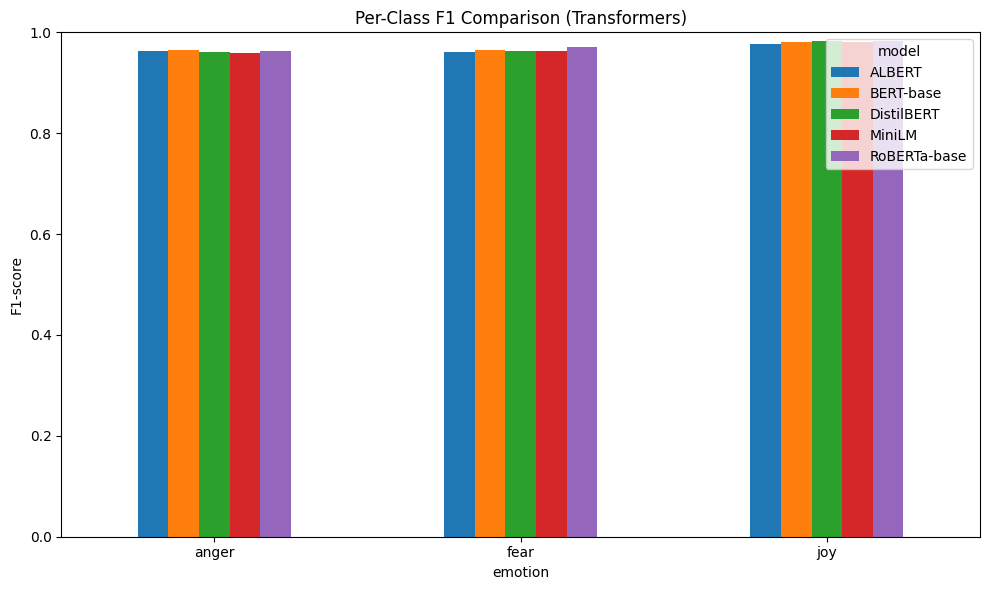

In [18]:
exclude_classes = ["macro avg", "weighted avg", "accuracy"]
class_mask = ~tf_df["class"].isin(exclude_classes)

per_class_df = tf_df[class_mask][["model", "class", "f1-score"]].copy()
per_class_df = per_class_df.rename(columns={"class": "emotion", "f1-score": "f1"})

pivot_f1 = per_class_df.pivot(index='emotion', columns='model', values='f1')

pivot_f1.plot(kind='bar', figsize=(10,6))
plt.ylabel('F1-score')
plt.title('Per-Class F1 Comparison (Transformers)')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()